In [2]:
import tempfile
from enum import Enum, unique
from pathlib import Path
from typing import List, Optional, Tuple, Union

import requests
from torchvision.datasets.utils import check_integrity

from health_multimodal.image import ImageInferenceEngine
from health_multimodal.image.data.transforms import create_chest_xray_transform_for_inference
from health_multimodal.image.model.pretrained import get_biovil_t_image_encoder
from health_multimodal.text.utils import BertEncoderType, get_bert_inference
from health_multimodal.vlp.inference_engine import ImageTextInferenceEngine

import matplotlib.pyplot as plt
from skimage import io
import os
from pathlib import Path
import pandas as pd


/cis/home/zwang/IBYDMT-med/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cis/home/zwang/IBYDMT-med/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
RESIZE = 512
CENTER_CROP_SIZE = 512

def _get_vlp_inference_engine() -> ImageTextInferenceEngine:
    image_inference = ImageInferenceEngine(
        image_model=get_biovil_t_image_encoder(),
        transform=create_chest_xray_transform_for_inference(resize=RESIZE, center_crop_size=CENTER_CROP_SIZE),
    )
    img_txt_inference = ImageTextInferenceEngine(
        image_inference_engine=image_inference,
        text_inference_engine=get_bert_inference(BertEncoderType.BIOVIL_T_BERT),
    )
    return img_txt_inference

### An example

image shape: (320, 389)


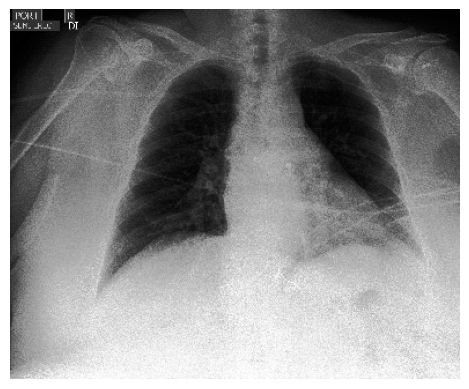

In [4]:

root = "/cis/home/zwang/IBYDMT-med/data"
image_name = "CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg"
image_path = os.path.join(root, image_name)
image = io.imread(image_path)
print("image shape:", image.shape)
plt.imshow(image, 'gray')
plt.axis('off')
plt.show()

### Get similarity score using `img_txt_inference.get_similarity_score_from_raw_data`

In [5]:

print("image_path:", Path(image_path).suffix)
query_text = "A photo of normal chest X-ray"
print("query_text:", query_text)
img_txt_inference = _get_vlp_inference_engine()
score = img_txt_inference.get_similarity_score_from_raw_data(
                image_path=Path(image_path), query_text=query_text
            )
print("similarity score:", score)

query_text = "A photo of abnormal chest X-ray"
print("query_text:", query_text)
img_txt_inference = _get_vlp_inference_engine()
score = img_txt_inference.get_similarity_score_from_raw_data(
                image_path=Path(image_path), query_text=query_text
            )
print("similarity score:", score)

image_path: .jpg
query_text: A photo of normal chest X-ray


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

similarity score: -0.055219173431396484
query_text: A photo of abnormal chest X-ray


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

similarity score: 0.3701849579811096


In [9]:
train_meta = os.path.join(root, "CheXpert-v1.0-small/train.csv")
train_meta = pd.read_csv(train_meta)
print(train_meta.loc[train_meta['Path'] == image_name, 'No Finding'].values[0])

1.0


### Get similarity score using cosine similarity between image and text features

In [33]:
_image_inference = ImageInferenceEngine(
        image_model=get_biovil_t_image_encoder(),
        transform=create_chest_xray_transform_for_inference(resize=RESIZE, center_crop_size=CENTER_CROP_SIZE),
    )
_text_inference = get_bert_inference(BertEncoderType.BIOVIL_T_BERT)

# get projected global embedding
image_features = _image_inference.get_projected_global_embedding(image_path=Path(image_path)).reshape(1, -1)
print("image_features shape:", image_features.shape)
text_features = _text_inference.get_embeddings_from_prompt(query_text)

print("text_features shape:", text_features.shape)
# compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_score = cosine_similarity(image_features, text_features)
print("similarity score:", similarity_score)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

image_features shape: torch.Size([1, 128])
text_features shape: torch.Size([1, 128])
similarity score: [[0.2713102]]


### Overall performance

In [10]:
train_meta = os.path.join(root, "CheXpert-v1.0-small/train.csv")
train_meta = pd.read_csv(train_meta)
train_meta.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [28]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
Predictions = []
Labels = []
test_meta = os.path.join(root, "CheXpert-v1.0-small/valid.csv")
test_meta = pd.read_csv(test_meta)
img_txt_inference = _get_vlp_inference_engine()
for i in tqdm(range(len(test_meta))):
    image_path = os.path.join(root, test_meta['Path'][i])
    query_text = "A normal chest X-ray with no finding"
    normal_score = img_txt_inference.get_similarity_score_from_raw_data(
                    image_path=Path(image_path), query_text=query_text
                )

    query_text = "An abnormal chest X-ray"
    abnormal_score = img_txt_inference.get_similarity_score_from_raw_data(
                    image_path=Path(image_path), query_text=query_text
                )
    if normal_score > abnormal_score:
        prediction = 'Normal'
    else:
        prediction = 'Abnormal'
    if train_meta['No Finding'][i] == 1:
        label = 'Normal'
    else:
        label = 'Abnormal'
    Predictions.append(prediction)
    Labels.append(label)
    # print(prediction, label)


#     if prediction == label:
#         Accs.append(1)
#     else:
#         Accs.append(0)
# print("Accuracy:", sum(Accs)/len(Accs))


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [29]:
# overall accuracy
import numpy as np
acc = np.sum(np.array(Predictions) == np.array(Labels)) / len(Predictions)
num_normal = np.sum(np.array(Labels) == 'Normal')
num_abnormal = np.sum(np.array(Labels) == 'Abnormal')
print("num_normal:", num_normal)
print("num_abnormal:", num_abnormal)
print("Accuracy:", acc)
# acc by class
acc_normal = np.sum(np.array(Predictions)[np.array(Labels) == 'Normal'] == 'Normal') / num_normal
acc_abnormal = np.sum(np.array(Predictions)[np.array(Labels) == 'Abnormal'] == 'Abnormal') / num_abnormal
print("Accuracy for normal:", acc_normal)
print("Accuracy for abnormal:", acc_abnormal)


num_normal: 33
num_abnormal: 201
Accuracy: 0.782051282051282
Accuracy for normal: 0.12121212121212122
Accuracy for abnormal: 0.8905472636815921


In [17]:
num_normal = len([i for i in train_meta['No Finding'][:100] if i == 1])
print("num_normal:", num_normal)

num_normal: 17


In [ ]:
### a normal x-ray
### a normal x-ray
# num_normal: 33
# num_abnormal: 201
# Accuracy: 0.7564102564102564
# Accuracy for normal: 0.21212121212121213
# Accuracy for abnormal: 0.845771144278607

In [44]:
# count values for each column, the first 5000 rows
concepts = list(train_meta.columns[5:])
for concept in concepts:
    print(concept, train_meta.loc[:5000, concept].value_counts())


No Finding No Finding
1.0    585
Name: count, dtype: int64
Enlarged Cardiomediastinum Enlarged Cardiomediastinum
 0.0    574
-1.0    281
 1.0    217
Name: count, dtype: int64
Cardiomegaly Cardiomegaly
 1.0    674
 0.0    335
-1.0    202
Name: count, dtype: int64
Lung Opacity Lung Opacity
 1.0    2213
 0.0     157
-1.0     128
Name: count, dtype: int64
Lung Lesion Lung Lesion
 1.0    206
 0.0     62
-1.0     34
Name: count, dtype: int64
Edema Edema
 1.0    1061
 0.0     558
-1.0     269
Name: count, dtype: int64
Consolidation Consolidation
 0.0    806
-1.0    567
 1.0    302
Name: count, dtype: int64
Pneumonia Pneumonia
-1.0    390
 1.0    137
 0.0     62
Name: count, dtype: int64
Atelectasis Atelectasis
-1.0    702
 1.0    636
 0.0     35
Name: count, dtype: int64
Pneumothorax Pneumothorax
 0.0    1345
 1.0     425
-1.0      58
Name: count, dtype: int64
Pleural Effusion Pleural Effusion
 1.0    1819
 0.0     989
-1.0     229
Name: count, dtype: int64
Pleural Other Pleural Other
 1.0   

In [31]:
train_meta_small = train_meta[:5000]
print(len(train_meta_small))
# save to csv
train_meta_small.to_csv(os.path.join(root, "CheXpert-v1.0-small/train_small.csv"), index=False)

5000
